In [51]:
# Synthetic Experiment for fairness 

# Load all necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from balancers import BinaryBalancer
from utils import generate_data, generate_a_hat, calc_gen_bounds, calculate_bias_metrics, eo_postprocess
sns.set_theme()

In [52]:
# Set experiment
exp = 2

# Generate data
n = 5000
e1 = 1
e2 = 1
b = 0.05
group = 1
X, a, y_prob, y_hat, y = generate_data(n,e1,e2,b,group,exp)
x1, x2, x3 = X[:,0], X[:,1], X[:,2]

# Organizing data
# using y
data = np.column_stack((x1,x2,x3,y_prob,y_hat,y,a))

# converting to dataframes
df = pd.DataFrame(data, columns = ['x1', 'x2', 'x3','y_prob','y_hat','y','a'])

# calculating base rates
r = df[(df['a'] == 1) & (df['y'] == 1)].shape[0]/df.shape[0]
s = df[(df['a'] == 0) & (df['y'] == 1)].shape[0]/df.shape[0]
v = df[(df['a'] == 1) & (df['y'] == 0)].shape[0]/df.shape[0]
w = df[(df['a'] == 0) & (df['y'] == 0)].shape[0]/df.shape[0]
min_rate = min(r,s,v,w)

# Calculate true bias
alpha,beta,tau,phi = calculate_bias_metrics(df)
bias_tpr = alpha - beta
bias_fpr = tau - phi
print('bias_tpr = ', bias_tpr)
print('bias_fpr = ', bias_fpr)
print('min_rate = ', min_rate)

bias_tpr =  0.14260000000000006
bias_fpr =  0.241
min_rate =  0.16


In [53]:
# Calculating bounds for different errors of a_hat
ah_mu = np.array([0.05,0.10])
iter = 1000

# true bias
bias_t = [bias_tpr for i in range(iter)]
bias_f = [bias_fpr for i in range(iter)]

# List to append array of delta values for each p
delta_noise_tpr = []
delta_noise_fpr = []

for k,mu in enumerate(ah_mu):

    errors = []
    u_bound_t = []
    u_bound_f = []
    l_bound_t = []
    l_bound_f = []

    i = 0
    while i < iter:

        # Generate a_hat
        a_hat = generate_a_hat(x3,b,mu,0.02)
        a_error = np.sum(a_hat != a)/a_hat.shape[0]
        if a_error >= min_rate:
            continue
        errors.append(a_error)

        # Using a_hat instead of a in the data
        # Using y
        data_ah = np.column_stack((x1,x2,x3,y_prob,y_hat,y,a_hat))

        # converting to dataframes (using a_hat)
        df_ah = pd.DataFrame(data_ah, columns = ['x1', 'x2', 'x3','y_prob','y_hat','y','a'])

        # Calculate est bias_tpr and bias_fpr
        alpha_hat, beta_hat, tau_hat, phi_hat = calculate_bias_metrics(df_ah)

        # Computing the upper bound and lower bounds under the assumption
        ub_t, lb_t = calc_gen_bounds(alpha_hat,beta_hat,a_error,r,s)
        ub_f, lb_f = calc_gen_bounds(tau_hat,phi_hat,a_error,v,w)
        
        l_bound_t.append(lb_t)
        l_bound_f.append(lb_f)
        u_bound_t.append(ub_t)
        u_bound_f.append(ub_f)

        i = i + 1

    # Calculate deltas 
    u_minus_b_tpr = np.abs(np.array(u_bound_t) - np.array(bias_t))
    b_tpr_minus_l = np.abs(np.array(bias_t) - np.array(l_bound_t))
    delta_noise_tpr.append(np.maximum(u_minus_b_tpr,b_tpr_minus_l))

    u_minus_b_fpr = np.abs(np.array(u_bound_f) - np.array(bias_f))
    b_fpr_minus_l = np.abs(np.array(bias_f) - np.array(l_bound_f))
    delta_noise_fpr.append(np.maximum(u_minus_b_fpr,b_fpr_minus_l))

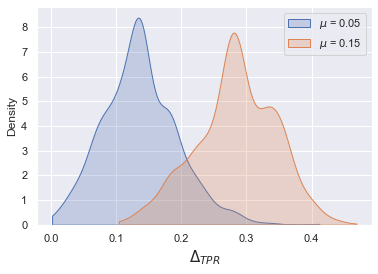

In [54]:
# Generate KDE Plots
sns.kdeplot(delta_noise_tpr[0], shade = True, label = '$\mu$ = 0.05',cut =0 )
sns.kdeplot(delta_noise_tpr[1], shade = True, label = '$\mu$ = 0.15',cut = 0)
# sns.kdeplot(delta_noise_tpr[2], shade = True, label = '$\epsilon_{3}$ = 0.15',cut = 0)
plt.legend()
plt.xlabel(r'$\Delta_{TPR}$', fontsize = 15)
plt.savefig('Figures/Exp2/bias_tpr_bound.png',bbox_inches="tight")

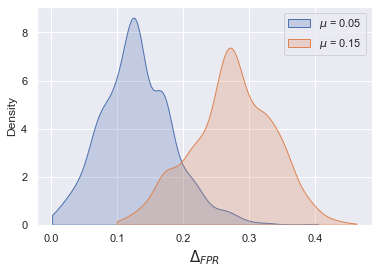

In [55]:
# Generate KDE Plots
sns.kdeplot(delta_noise_fpr[0], shade = True, label = '$\mu$ = 0.05', cut = 0)
sns.kdeplot(delta_noise_fpr[1], shade = True, label = '$\mu$ = 0.15', cut = 0)
plt.legend()
plt.xlabel(r'$\Delta_{FPR}$', fontsize = 15)
plt.savefig('Figures/Exp2/bias_fpr_bound.png',bbox_inches="tight")

Enforcing Fairness

In [59]:
# Set experiment
exp = 2

# Generate data
n = 5000
e1 = 1
e2 = 1
b = 0.05
group = 1
X, a, y_prob, y_hat, y  = generate_data(n,e1,e2,b,group,exp)
x1, x2, x3 = X[:,0], X[:,1], X[:,2]

# Organizing data
# using y
data = np.column_stack((x1,x2,x3,y_prob,y_hat,y,a))

# converting to dataframes
df = pd.DataFrame(data, columns = ['x1', 'x2', 'x3', 'y_prob', 'y_hat', 'y','a'])

# calculating base rates
r = df[(df['a'] == 1) & (df['y'] == 1)].shape[0]/df.shape[0]
s = df[(df['a'] == 0) & (df['y'] == 1)].shape[0]/df.shape[0]
v = df[(df['a'] == 1) & (df['y'] == 0)].shape[0]/df.shape[0]
w = df[(df['a'] == 0) & (df['y'] == 0)].shape[0]/df.shape[0]
min_rate = np.min([r,s,v,w])

# Calculate true bias_tpr and bias_fpr
alpha, beta, tau, phi = calculate_bias_metrics(df)
bias_tpr = alpha - beta
bias_fpr = tau - phi
print('bias_tpr = ', bias_tpr)
print('bias_fpr = ', bias_fpr)
print('min_rate = ', min_rate)

bias_tpr =  0.14329999999999998
bias_fpr =  0.24950000000000003
min_rate =  0.1596


In [60]:
# Average noise on a_hat where the noise is normally distributed
mu = 0.05

# Original bias
iter = 100
bias_t_o = [bias_tpr for i in range(iter)]
bias_f_o = [bias_fpr for i in range(iter)]

# Arrays to populated
errors = []
u_bound_t_o = []
u_bound_f_o = []
l_bound_t_o = []
l_bound_f_o= []
u_bound_t_n = []
u_bound_f_n = []
l_bound_t_n = []
l_bound_f_n = []
bias_t_n = []
bias_f_n = []

i = 0
while i < iter:

    # Generate a_hat
    a_hat = generate_a_hat(x3,b,mu,0.02)
    a_error = np.sum(a_hat != a)/a_hat.shape[0]
    if a_error >= min_rate:
        continue
    errors.append(a_error)

    # Using a_hat instead of a in the data
    # Using y
    data_ah = np.column_stack((x1,x2,x3,y_prob,y_hat,y,a_hat))

    # converting to dataframes (using a_hat)
    df_ah = pd.DataFrame(data_ah, columns = ['x1', 'x2', 'x3','y_prob','y_hat', 'y','a'])

    # Calculate est bias_tpr and bias_fpr
    alpha_hat, beta_hat, tau_hat, phi_hat = calculate_bias_metrics(df_ah)

    # Computing the upper bound and lower bounds under the assumption
    ub_t_o, lb_t_o = calc_gen_bounds(alpha_hat,beta_hat,a_error,r,s)
    ub_f_o, lb_f_o = calc_gen_bounds(tau_hat,phi_hat,a_error,v,w)

    # Calculating new upper and lower bounds with fair f

    # Enforce fairness wrt a_hat
    fair_ah_yh, fair_model = eo_postprocess(df_ah)

    # Calculate new bias_estimates
    df_ah_fair = df_ah.copy(deep = True)
    df_ah_fair.y_hat = fair_ah_yh

    # Calculate est bias_tpr and bias_fpr
    alpha_hat_f, beta_hat_f, tau_hat_f, phi_hat_f = calculate_bias_metrics(df_ah_fair)

    # Computing the new upper bound and lower bounds under the assumption
    ub_t_n, lb_t_n = calc_gen_bounds(alpha_hat_f,beta_hat_f,a_error,r,s)
    ub_f_n, lb_f_n = calc_gen_bounds(tau_hat_f,phi_hat_f,a_error,v,w)

    # Calculate new true bias wrt to a with fair f
    yh_fair = fair_model.predict(df.y_prob.values,df.a.values)
    df_fair = df.copy(deep=True)
    df_fair.y_hat = yh_fair
    alpha_n, beta_n, tau_n, phi_n = calculate_bias_metrics(df_fair)
    
    # Old and new upper and lower bounds and bias with fair f
    bias_t_n.append(alpha_n - beta_n)
    bias_f_n.append(tau_n - phi_n)
    l_bound_t_o.append(lb_t_o)
    l_bound_f_o.append(lb_f_o)
    u_bound_t_o.append(ub_t_o)
    u_bound_f_o.append(ub_f_o)
    l_bound_t_n.append(lb_t_n)
    l_bound_f_n.append(lb_f_n)
    u_bound_t_n.append(ub_t_n)
    u_bound_f_n.append(ub_f_n)
    i = i + 1

# Computing max distributions
max_t_o = np.maximum(np.abs(u_bound_t_o),np.abs(l_bound_t_o))
max_t_n = np.maximum(np.abs(u_bound_t_n),np.abs(l_bound_t_n))
max_f_o = np.maximum(np.abs(u_bound_f_o),np.abs(l_bound_f_o))
max_f_n = np.maximum(np.abs(u_bound_f_n),np.abs(l_bound_f_n))

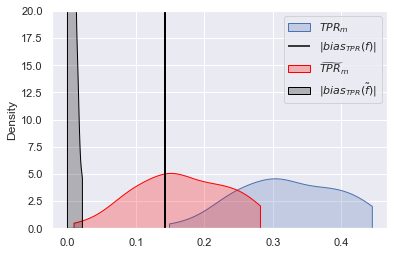

In [61]:
# Kde plots: Upper bound
sns.kdeplot(max_t_o,shade=True, cut = 0, label = '$TPR_{m}$')
plt.vlines(np.array(np.abs(bias_t_o)),ymin=0,ymax=55, label = r'$|bias_{TPR}(f)|$', color = 'black')
sns.kdeplot(max_t_n,shade=True, cut = 0,label = r'$\widetilde{TPR}_{m}$', color = 'red')
# plt.vlines(np.array(np.abs(bias_t_n)),ymin=0,ymax=10, label = r'$|bias_{TPR}(\tilde{f})|$', color = 'black')
sns.kdeplot(np.array(np.abs(bias_t_n)),shade=True, cut = 0, label = r'$|bias_{TPR}(\tilde{f})|$',color='black')
plt.legend()
plt.ylim([0,20])
plt.savefig('Figures/Exp2/bias_tpr_control.png',bbox_inches="tight")

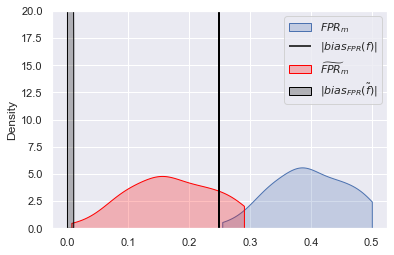

In [62]:
# Kde plots: fpr
sns.kdeplot(max_f_o,shade=True, cut = 0, label = '$FPR_{m}$')
plt.vlines(np.array(np.abs(bias_f_o)),ymin=0,ymax=100, label = r'$|bias_{FPR}(f)|$', color = 'black')
sns.kdeplot(max_f_n,shade=True, cut = 0,label = r'$\widetilde{FPR}_{m}$', color = 'red')
sns.kdeplot(np.array(np.abs(bias_f_n)),shade=True, cut = 0, label = r'$|bias_{FPR}(\tilde{f})|$',color='black')
plt.legend()
plt.ylim([0,20])
plt.savefig('Figures/Exp2/bias_fpr_control.png',bbox_inches="tight")
# plt.legend(loc ='upper center')